#### This is the demonstration of the proposed method using the AlexNet backbone and Mendeley V2 dataset.

In [1]:
import torch
import torchvision
from torch.nn import functional as F

import os
import cv2
import numpy as np
from sklearn import metrics
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from model import CNN 
from dataset import DCADataset 
from loss_fn import cross_entropy_with_dca_loss as ce_dca_loss
import utilities as UT


In [2]:
def get_ece(logits, labels, n_bins = 15):
    # This function is based on https://github.com/gpleiss/temperature_scaling
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    ece = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean() # weight of current bin            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


def get_mce(logits, labels, n_bins = 15):
    # This function is based on https://github.com/gpleiss/temperature_scaling
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    mce = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            error = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            if(error>mce):
                mce = error
                
    return mce

In [3]:
def train(net, opt, scheduler, BETA):
    t = trange(EPOCHS, desc=' ', leave=True)

    train_hist = []
    test_hist = []
    pred_result = []
    old_acc = 0
    for e in t:    
        y_true = []
        y_pred = []
        test_y_true = []
        test_y_pred = []

        # training
        net.train()
        for step, (img, label, _) in enumerate(dataloader):
            img = img.float().to(device)
            label = label.long().to(device)
            opt.zero_grad()
            out = net(img)
            loss = ce_dca_loss(out, label, weights=LOSS_WEIGHTS.to(device), beta=BETA) # weighted cross-entropy /w DCA
            y_true, y_pred = UT.assemble_labels(step, y_true, y_pred, label, out)
            loss.backward()
            opt.step()
            t.set_description("step: %i, loss: %.4f" %(step, loss.item()))

        acc = float(torch.sum(torch.max(y_pred, 1)[1]==y_true))/ float(len(y_pred))
        auc = metrics.roc_auc_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy()[:,1])
        f1 = metrics.f1_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        precision = metrics.precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        recall = metrics.recall_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        ap = metrics.average_precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy()) #average_precision
        ac = torch.mean(torch.max(F.softmax(y_pred, dim=1), 1)[0]) # average predict confidence        
        ece = get_ece(y_pred, y_true)
        mce = get_mce(y_pred, y_true)    

        scheduler.step()

        # testing
        net.eval()
        with torch.no_grad():
            for step, (img, label, _) in enumerate(val_dataloader):
                img = img.float().to(device)
                label = label.long().to(device)
                out = net(img)
                test_loss = ce_dca_loss(out, label, weights=LOSS_WEIGHTS.to(device), beta=BETA)

                test_y_true, test_y_pred = UT.assemble_labels(step, test_y_true, test_y_pred, label, out)

        test_acc = float(torch.sum(torch.max(test_y_pred, 1)[1]==test_y_true))/ float(len(test_y_pred))
        test_auc = metrics.roc_auc_score(test_y_true.cpu().detach().numpy(), test_y_pred.cpu().detach().numpy()[:,1])
        test_f1 = metrics.f1_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_precision = metrics.precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_recall = metrics.recall_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_ap = metrics.average_precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy()) #average_precision
        test_ac = torch.mean(torch.max(F.softmax(test_y_pred, dim=1), 1)[0]) # average predict confidence
        test_ece = get_ece(test_y_pred, test_y_true)
        test_mce = get_mce(test_y_pred, test_y_true)

        train_hist.append([loss.item(), acc, auc, f1, precision, recall, ap, ac.item(), ece.item(), mce.item()])        
        test_hist.append([test_loss.item(), test_acc, test_auc, test_f1, test_precision, test_recall, test_ap, test_ac.item(), test_ece.item(), test_mce.item()])

        if(test_acc>old_acc):
            print('Epoch: %d\n  -Train Acc %.4f  -Train AC %.4f  - Train ECE %.4f  - Train MCE %.4f\n  -Val Acc   %.4f  -Val AC   %.4f  - Val ECE   %.4f  - Val MCE   %.4f' 
                  %(e+1, acc, ac, ece, mce, test_acc, test_ac, test_ece, test_mce))
            old_acc = test_acc

    return train_hist, test_hist

In [4]:
FEATURE = 'Alex'
BATCH_SIZE = 64
FEATURE_SHAPE=(256,25,25) 

DATASET = 'Mendeley'
PATH_TRAIN = './Mendeley_train_list.csv'
PATH_TEST = './Mendeley_test_list.csv'
LOSS_WEIGHTS = torch.tensor([0.735, 0.265]) 
NUM_OF_CLASS = 2

GPU = 3
EPOCHS = 21
LR=0.0001
RESIZE = True
PRETRAINED = True
REQUIRES_GRAD = False

device = torch.device('cuda:'+str(GPU) if torch.cuda.is_available() else 'cpu')

dataset = DCADataset(label_file=PATH_TRAIN, 
                     resize=RESIZE, 
                     augmentation=True)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         num_workers=4, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         drop_last=True)

val_dataset = DCADataset(label_file=PATH_TEST, 
                         resize=RESIZE, 
                         augmentation=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             num_workers=4, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False, 
                                             drop_last=True)


file_name: /data/scratch/gliang/data/lung_xray/Chest_X-Ray_Images_Pneumonia/train/NORMAL/NORMAL2-IM-0621-0001.jpeg


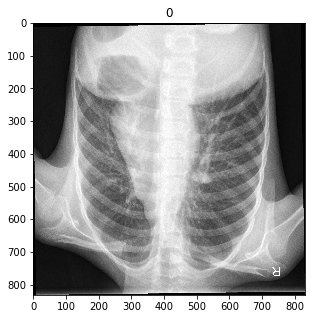

In [5]:
# show one random sample
dataiter = iter(dataloader)    
images, labels, full_path = dataiter.next()
UT.imshow(images, labels, full_path)

### Beta=1

In [6]:
BETA=1

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 0.3632:   5%|▍         | 1/21 [03:21<1:07:02, 201.12s/it]

Epoch: 1
  -Train Acc 0.8827  -Train AC 0.7448  - Train ECE 0.1379  - Train MCE 0.2115
  -Val Acc   0.8403  -Val AC   0.7443  - Val ECE   0.1088  - Val MCE   0.1745


step: 80, loss: 0.3055:  14%|█▍        | 3/21 [10:06<1:00:41, 202.29s/it]

Epoch: 3
  -Train Acc 0.9464  -Train AC 0.8428  - Train ECE 0.1060  - Train MCE 0.1904
  -Val Acc   0.8455  -Val AC   0.7982  - Val ECE   0.0599  - Val MCE   0.0771


step: 80, loss: 0.2491:  24%|██▍       | 5/21 [16:46<53:40, 201.26s/it]  

Epoch: 5
  -Train Acc 0.9695  -Train AC 0.8917  - Train ECE 0.0788  - Train MCE 0.1811
  -Val Acc   0.8490  -Val AC   0.8353  - Val ECE   0.0504  - Val MCE   0.1808


step: 80, loss: 0.0326: 100%|██████████| 21/21 [1:06:22<00:00, 189.66s/it]


Text(0.5, 1.0, 'Loss & Accuracy')

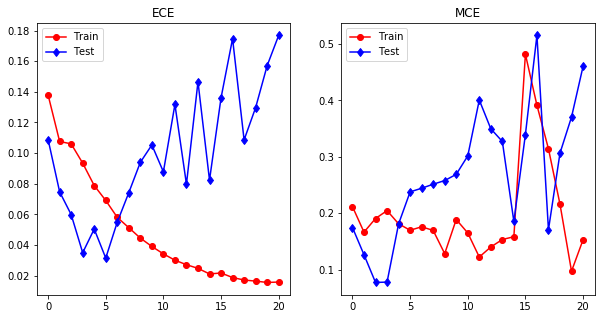

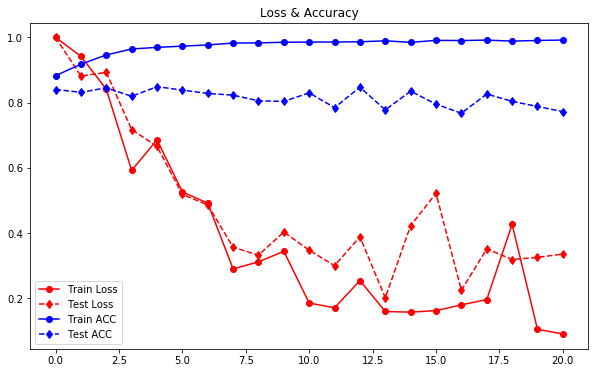

In [8]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')

### beta=5

In [6]:
BETA=5

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 1.2883:   5%|▍         | 1/21 [02:59<59:57, 179.90s/it]

Epoch: 1
  -Train Acc 0.7429  -Train AC 0.6434  - Train ECE 0.1012  - Train MCE 0.1651
  -Val Acc   0.7587  -Val AC   0.6799  - Val ECE   0.0815  - Val MCE   0.1549


step: 80, loss: 0.6243:  10%|▉         | 2/21 [05:50<55:30, 175.29s/it]  

Epoch: 2
  -Train Acc 0.8331  -Train AC 0.7177  - Train ECE 0.1155  - Train MCE 0.1920
  -Val Acc   0.8385  -Val AC   0.7182  - Val ECE   0.1254  - Val MCE   0.1970


step: 80, loss: 0.7799:  14%|█▍        | 3/21 [08:36<51:37, 172.09s/it]  

Epoch: 3
  -Train Acc 0.8709  -Train AC 0.7665  - Train ECE 0.1249  - Train MCE 0.2148
  -Val Acc   0.8646  -Val AC   0.7625  - Val ECE   0.1049  - Val MCE   0.2100


step: 80, loss: 0.3679:  24%|██▍       | 5/21 [14:25<46:10, 173.17s/it]  

Epoch: 5
  -Train Acc 0.8848  -Train AC 0.8274  - Train ECE 0.0807  - Train MCE 0.1464
  -Val Acc   0.8715  -Val AC   0.8200  - Val ECE   0.0534  - Val MCE   0.1862


step: 80, loss: 0.6414:  43%|████▎     | 9/21 [25:47<34:23, 171.93s/it]

Epoch: 9
  -Train Acc 0.9010  -Train AC 0.8699  - Train ECE 0.0584  - Train MCE 0.2503
  -Val Acc   0.8733  -Val AC   0.8380  - Val ECE   0.0501  - Val MCE   0.1964


step: 80, loss: 0.4071:  62%|██████▏   | 13/21 [37:34<23:07, 173.39s/it]

Epoch: 13
  -Train Acc 0.9441  -Train AC 0.9015  - Train ECE 0.0535  - Train MCE 0.1324
  -Val Acc   0.8767  -Val AC   0.8695  - Val ECE   0.0207  - Val MCE   0.2051


step: 80, loss: 0.2864:  67%|██████▋   | 14/21 [40:34<20:17, 173.90s/it]

Epoch: 14
  -Train Acc 0.9431  -Train AC 0.9105  - Train ECE 0.0454  - Train MCE 0.1798
  -Val Acc   0.8802  -Val AC   0.8715  - Val ECE   0.0322  - Val MCE   0.1006


step: 80, loss: 0.2127:  81%|████████  | 17/21 [49:24<11:37, 174.35s/it]

Epoch: 17
  -Train Acc 0.9701  -Train AC 0.9302  - Train ECE 0.0413  - Train MCE 0.1172
  -Val Acc   0.9028  -Val AC   0.8981  - Val ECE   0.0144  - Val MCE   0.1646


step: 80, loss: 0.0964: 100%|██████████| 21/21 [1:01:09<00:00, 174.75s/it]


Text(0.5, 1.0, 'Loss & Accuracy')

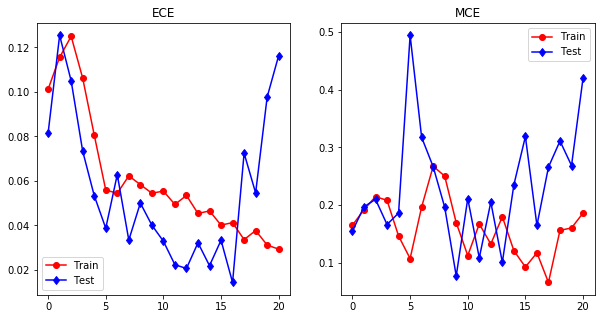

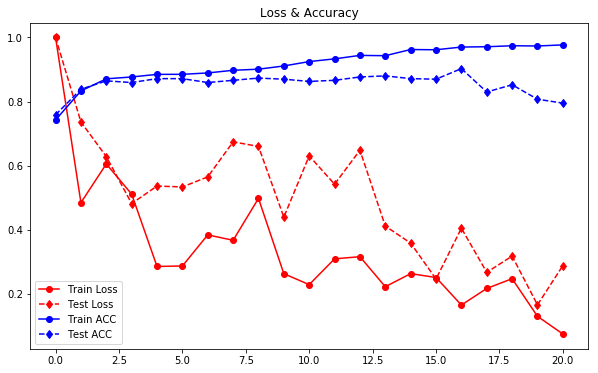

In [7]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')

### Beta=10

In [8]:
BETA=5

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 0.7635:   5%|▍         | 1/21 [02:58<59:36, 178.84s/it]

Epoch: 1
  -Train Acc 0.8304  -Train AC 0.7143  - Train ECE 0.1161  - Train MCE 0.1583
  -Val Acc   0.8455  -Val AC   0.7565  - Val ECE   0.1002  - Val MCE   0.2011


step: 80, loss: 0.8229:  10%|▉         | 2/21 [05:57<56:39, 178.91s/it]  

Epoch: 2
  -Train Acc 0.8850  -Train AC 0.8032  - Train ECE 0.0851  - Train MCE 0.1373
  -Val Acc   0.8542  -Val AC   0.7949  - Val ECE   0.0628  - Val MCE   0.1607


step: 80, loss: 0.5021:  33%|███▎      | 7/21 [20:39<41:18, 177.04s/it]  

Epoch: 7
  -Train Acc 0.9309  -Train AC 0.8931  - Train ECE 0.0430  - Train MCE 0.0815
  -Val Acc   0.8698  -Val AC   0.8394  - Val ECE   0.0408  - Val MCE   0.0742


step: 80, loss: 0.2134: 100%|██████████| 21/21 [1:01:40<00:00, 176.20s/it]


Text(0.5, 1.0, 'Loss & Accuracy')

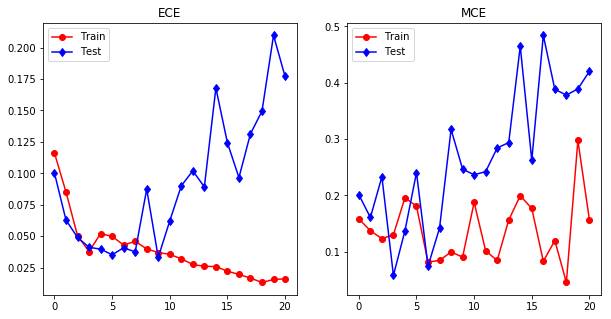

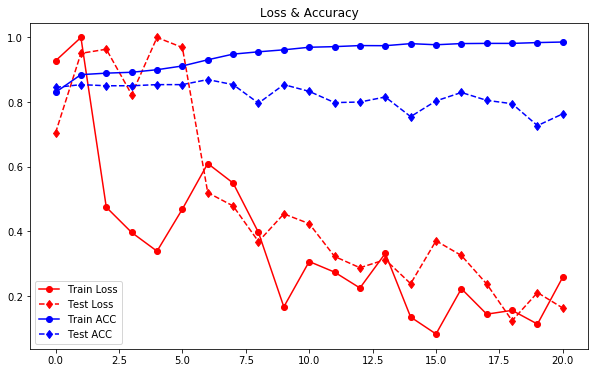

In [9]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')

### Beta=15

In [10]:
BETA=15

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 1.1486:   5%|▍         | 1/21 [02:54<58:18, 174.93s/it]

Epoch: 1
  -Train Acc 0.4680  -Train AC 0.5724  - Train ECE 0.1044  - Train MCE 0.1932
  -Val Acc   0.5573  -Val AC   0.5878  - Val ECE   0.0578  - Val MCE   0.1635


step: 80, loss: 2.5303:  10%|▉         | 2/21 [05:49<55:22, 174.89s/it]  

Epoch: 2
  -Train Acc 0.7313  -Train AC 0.6141  - Train ECE 0.1179  - Train MCE 0.1984
  -Val Acc   0.8385  -Val AC   0.6777  - Val ECE   0.1622  - Val MCE   0.2358


step: 80, loss: 1.7909:  14%|█▍        | 3/21 [08:40<52:05, 173.61s/it]  

Epoch: 3
  -Train Acc 0.8584  -Train AC 0.7335  - Train ECE 0.1328  - Train MCE 0.2354
  -Val Acc   0.8472  -Val AC   0.7502  - Val ECE   0.1208  - Val MCE   0.2110


step: 80, loss: 1.3981:  24%|██▍       | 5/21 [14:16<45:41, 171.34s/it]  

Epoch: 5
  -Train Acc 0.8835  -Train AC 0.8367  - Train ECE 0.0891  - Train MCE 0.1761
  -Val Acc   0.8594  -Val AC   0.8342  - Val ECE   0.0638  - Val MCE   0.4904


step: 80, loss: 0.9988:  33%|███▎      | 7/21 [19:58<39:57, 171.22s/it]

Epoch: 7
  -Train Acc 0.8868  -Train AC 0.8688  - Train ECE 0.0456  - Train MCE 0.1001
  -Val Acc   0.8646  -Val AC   0.8467  - Val ECE   0.0476  - Val MCE   0.4809


step: 80, loss: 0.8344:  38%|███▊      | 8/21 [22:47<37:01, 170.92s/it]

Epoch: 8
  -Train Acc 0.8870  -Train AC 0.8721  - Train ECE 0.0491  - Train MCE 0.1947
  -Val Acc   0.8698  -Val AC   0.8585  - Val ECE   0.0418  - Val MCE   0.4268


step: 80, loss: 1.1324:  67%|██████▋   | 14/21 [40:50<20:25, 175.03s/it]

Epoch: 14
  -Train Acc 0.9215  -Train AC 0.8971  - Train ECE 0.0400  - Train MCE 0.1335
  -Val Acc   0.8715  -Val AC   0.8720  - Val ECE   0.0330  - Val MCE   0.3470


step: 80, loss: 1.1794:  71%|███████▏  | 15/21 [43:32<17:25, 174.19s/it]

Epoch: 15
  -Train Acc 0.9296  -Train AC 0.9015  - Train ECE 0.0406  - Train MCE 0.1648
  -Val Acc   0.8924  -Val AC   0.8726  - Val ECE   0.0372  - Val MCE   0.2290


step: 80, loss: 0.2411: 100%|██████████| 21/21 [1:01:03<00:00, 174.45s/it]


Text(0.5, 1.0, 'Loss & Accuracy')

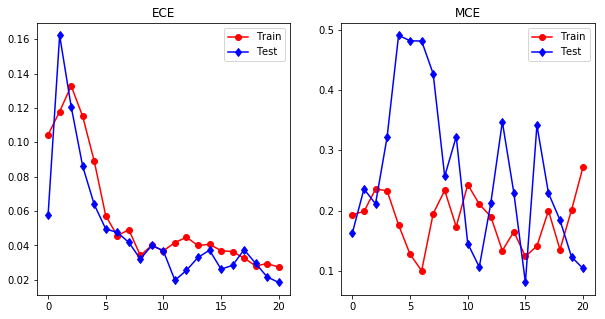

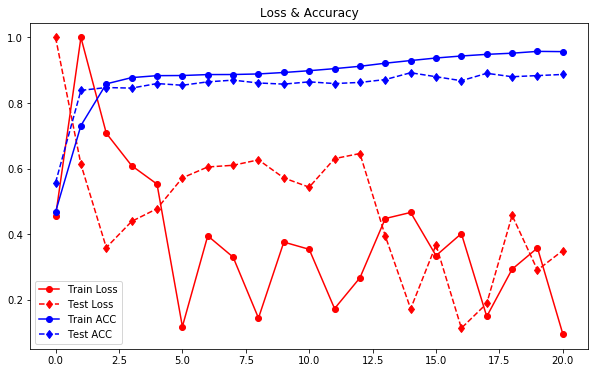

In [11]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')

### Beta=20

In [12]:
BETA = 20

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 1.0494:   5%|▍         | 1/21 [02:53<57:47, 173.40s/it]

Epoch: 1
  -Train Acc 0.8237  -Train AC 0.7204  - Train ECE 0.1033  - Train MCE 0.1456
  -Val Acc   0.8663  -Val AC   0.7448  - Val ECE   0.1216  - Val MCE   0.1601


step: 80, loss: 0.2785:  38%|███▊      | 8/21 [23:05<37:31, 173.17s/it]  

Epoch: 8
  -Train Acc 0.8999  -Train AC 0.8878  - Train ECE 0.0363  - Train MCE 0.1674
  -Val Acc   0.8715  -Val AC   0.8543  - Val ECE   0.0313  - Val MCE   0.2050


step: 80, loss: 0.9999:  43%|████▎     | 9/21 [26:01<34:42, 173.51s/it]

Epoch: 9
  -Train Acc 0.9018  -Train AC 0.8926  - Train ECE 0.0394  - Train MCE 0.1965
  -Val Acc   0.8750  -Val AC   0.8723  - Val ECE   0.0490  - Val MCE   0.1871


step: 80, loss: 0.1250: 100%|██████████| 21/21 [1:01:55<00:00, 176.92s/it]


Text(0.5, 1.0, 'Loss & Accuracy')

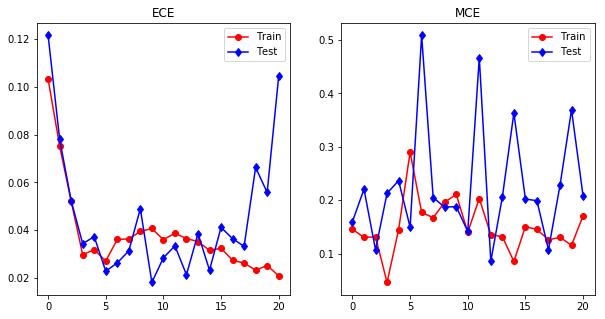

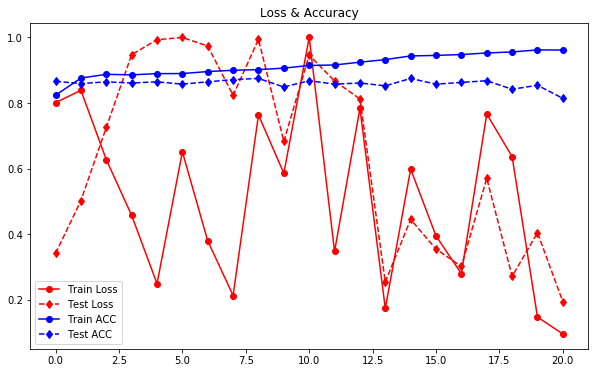

In [13]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')

### Beta=25

In [14]:
BETA = 25

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 4.0546:   5%|▍         | 1/21 [02:47<55:43, 167.17s/it]

Epoch: 1
  -Train Acc 0.7674  -Train AC 0.6865  - Train ECE 0.0809  - Train MCE 0.1166
  -Val Acc   0.8073  -Val AC   0.7035  - Val ECE   0.1038  - Val MCE   0.1557


step: 80, loss: 1.2688:  10%|▉         | 2/21 [05:44<54:28, 172.03s/it]  

Epoch: 2
  -Train Acc 0.8281  -Train AC 0.7593  - Train ECE 0.0688  - Train MCE 0.0933
  -Val Acc   0.8646  -Val AC   0.7380  - Val ECE   0.1265  - Val MCE   0.1682


step: 80, loss: 1.1209: 100%|██████████| 21/21 [1:02:05<00:00, 177.38s/it]

Epoch: 21
  -Train Acc 0.9670  -Train AC 0.9490  - Train ECE 0.0212  - Train MCE 0.0900
  -Val Acc   0.8681  -Val AC   0.9058  - Val ECE   0.0506  - Val MCE   0.1863


Text(0.5, 1.0, 'Loss & Accuracy')

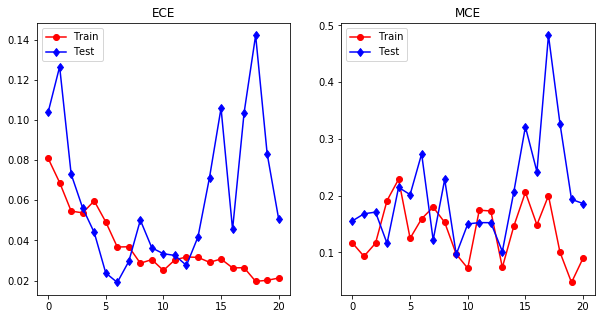

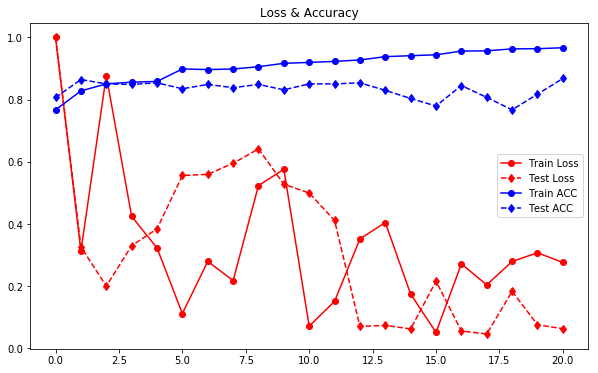

In [15]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:,8], 'r-o')
plt.plot(test_hist[:,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE')
plt.subplot(1,2,2)
plt.plot(train_hist[:,9], 'r-o')
plt.plot(test_hist[:,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE')


plt.figure(figsize=(10,6))
train_loss = train_hist[:,0]
train_acc = train_hist[:,1]
test_loss = test_hist[:,0]
test_acc = test_hist[:,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy')